In [1]:
import numpy as np
import sharppy.sharptab.thermo as thermo
from pylab import *
%matplotlib inline
from datetime import datetime

# IMPORTANT CONSTANTS.
k_d = 0.2854
C = ZEROCNK = 273.15
lambda_factor = 1./k_d
A = 2675. # Kelvin
a = 17.67
b = 243.5 # Kelvin
p_0 = 1000.
ROCP = 0.28571426
k_0 = 3036 # K
k_1 = 1.78
k_2 = 0.448
k_3 = 0
nu = k_d
epsilon = 0.622 #mb

def satlift(p, thetam, conv=0.1):
    '''
    Returns the temperature (C) of a saturated parcel (thm) when lifted to a
    new pressure level (hPa).  An implementation of the Secant/Wobus function
    method per Davies-Jones (2008).
    
    Parameters
    ----------
    p : number
        Pressure to which parcel is raised (hPa)
    thetam : number
        Saturated Potential Temperature of parcel (C)
    conv : number
        Convergence criteria (C)
        default: 0.1 C
        
    Returns
    -------
    Temperature (C) of saturated parcel at new level
    '''
    #if type(p) == type(np.array([p])) or type(thetam) == type(np.array([thetam])):
    if np.fabs(p - 1000.) - 0.001 <= 0: return thetam
    eor = 999
    while np.fabs(eor) - conv > 0:
        if eor == 999:                  # First Pass
            pwrp = np.power((p / 1000.),ROCP)
            t1 = (thetam + ZEROCNK) * pwrp - ZEROCNK
            e1 = thermo.wobf(t1) - thermo.wobf(thetam)
            rate = 1
        else:                           # Successive Passes
            rate = (t2 - t1) / (e2 - e1)
            t1 = t2
            e1 = e2
        t2 = t1 - (e1 * rate)
        e2 = (t2 + ZEROCNK) / pwrp - ZEROCNK
        e2 += thermo.wobf(t2) - thermo.wobf(e2) - thetam
        eor = e2 * rate
    return t2 - eor


def wetlift(p, t, p2, conv=0.1):
    '''
    Lifts a parcel moist adiabatically to its new level.
    Parameters
    -----------
    p : number
        Pressure of initial parcel (hPa)
    t : number
        Temperature of initial parcel (C)
    p2 : number
        Pressure of final level (hPa)
    conv : number
        Wobus method convergence criteria (C)
        default: 0.1 C   
        
    Returns
    -------
    Temperature (C)
    '''
    thta = theta(p, t, 1000.)
    if thta is np.ma.masked or p2 is np.ma.masked:
        return np.ma.masked
    thetam = thta - thermo.wobf(thta) + thermo.wobf(t)
    return satlift(p2, thetam, conv)


def theta(p, t, p2=1000.):
    '''
    Returns the potential temperature (C) of a parcel.
    Parameters
    ----------
    p : number, numpy array
        The pressure of the parcel (hPa)
    t : number, numpy array
        Temperature of the parcel (C)
    p2 : number, numpy array (default 1000.)
        Reference pressure level (hPa)
    Returns
    -------
    Potential temperature (C)
    '''
    return ((t + ZEROCNK) * np.power((p2 / p),ROCP)) - ZEROCNK

def lcltemp(t, td):
    '''
    Returns the temperature (C) of a parcel when raised to its LCL.
    Parameters
    ----------
    t : number, numpy array
        Temperature of the parcel (C)
    td : number, numpy array
        Dewpoint temperature of the parcel (C)
    Returns
    -------
    Temperature (C) of the parcel at it's LCL.
    '''
    s = t - td
    dlt = s * (1.2185 + 0.001278 * t + s * (-0.00219 + 1.173e-5 * s -
        0.0000052 * t))
    return t - dlt

def ktoc(t):
    '''
    Convert temperature from Kelvin to Celsius
    Parameters
    ----------
    t : number, numpy array
        The temperature in Kelvin
    Returns
    -------
    Temperature in Celsius (number or numpy array)
    '''
    return t - ZEROCNK


def ctok(t):
    '''
    Convert temperature from Celsius to Kelvin
    Parameters
    ----------
    t : number, numpy array
        The temperature in Celsius
    Returns
    -------
    Temperature in Kelvin (number or numpy array)
    '''
    return t + ZEROCNK

def thalvl(theta, t):
    '''
    Returns the level (hPa) of a parcel.
    Parameters
    ----------
    theta : number, numpy array
        Potential temperature of the parcel (C)
    t : number, numpy array
        Temperature of the parcel (C)
    Returns
    -------
    Pressure Level (hPa [float]) of the parcel
    '''

    t = t + ZEROCNK
    theta = theta + ZEROCNK
    return 1000. / (np.power((theta / t),(1./ROCP)))

def drylift(p, t, td):
    '''
    Lifts a parcel to the LCL and returns its new level and temperature.
    Parameters
    ----------
    p : number, numpy array
        Pressure of initial parcel in hPa
    t : number, numpy array
        Temperature of inital parcel in C
    td : number, numpy array
        Dew Point of initial parcel in C
    Returns
    -------
    p2 : number, numpy array
        LCL pressure in hPa
    t2 : number, numpy array
        LCL Temperature in C
    '''
    t2 = lcltemp(t, td)
    p2 = thalvl(theta(p, t, 1000.), t2)
    return p2, t2

def e_s(t):
    # t is in Celsius, returns mb
    return 6.122 * np.exp((a * t)/(t + b)) 

def e2r(e, p):
    # both e and p are in mb, returns unitless mixing ratio
    return (epsilon * e)/(p-e)

def thetae(p, t, td):
    # Returns in Kelvin (from Bolton 1980, Eq 39.)
    p_lcl, t_lcl = drylift(p, t, td) # not similar to the formula used in Bolton 1980
    r = e2r(e_s(td), p)
    theta_dl = ctok(t) * (np.power(1000./(p - e_s(t)), k_d) * np.power(ctok(t)/ctok(t_lcl),r * (0.28 * 10**-3)))
    term1 = ((3036/ctok(t_lcl)) - 1.78)
    term2 = (r * (1. + ((0.448) * r)))
    thetae = theta_dl * np.exp(term1 * term2)
    return thetae

def equivalent_temperature(thetae, p):
    # thetae must be passed in Kelvin and p must be in mb
    # returns in Kelvin
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    return thetae * nondim_pres

def guess_wetbulb(thetae, p):
    t_e = equivalent_temperature(thetae, p) # returns in Kelvin
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    normalized_t_e = np.power(C / t_e, lambda_factor) # Unitless
    D = np.power(0.1859 * (p/1000.) + 0.6512, -1)
    r_s = e2r(e_s(ktoc(t_e)), p)# * (1./1000.)
    deriv = ((a * b)/np.power(ktoc(t_e) + b,2))

    t_w = np.empty(len(t_e))
    k1_pi = -38.5*np.power(nondim_pres, 2) + 137.81*nondim_pres - 53.737 # RDJ 2007 Eq 4.3
    k2_pi = -4.392*np.power(nondim_pres, 2) + 56.831*nondim_pres - 0.384 # RDJ 2007 Eq 4.4

    # Criteria 1 (RDJ 2007 Eq 4.8)
    idx = np.where(normalized_t_e > D)#[0]
    t_w[idx] = ktoc(t_e[idx]) - ((A * r_s[idx]) / (1 + A*r_s[idx]*deriv[idx]))
    # Criteria 2 (RDJ 2007 Eq 4.9)
    idx = np.where((1 <= normalized_t_e) & (normalized_t_e <= D))#[0]
    t_w[idx] = k1_pi[idx] - k2_pi[idx] * normalized_t_e[idx]
    # Criteria 3 (RDJ 2007 Eq 4.10)
    idx = np.where((0.4 <= normalized_t_e) & (normalized_t_e < 1))#[0]
    t_w[idx] = (k1_pi[idx] - 1.21) - ((k2_pi[idx] - 1.21) * normalized_t_e[idx])
    # Criteria 4 (RDJ 2007 Eq 4.11)
    idx = np.where(normalized_t_e < 0.4)#[0]
    t_w[idx] = (k1_pi[idx] - 2.66) - ((k2_pi[idx] - 1.21) * normalized_t_e[idx]) + (0.58 * np.power(normalized_t_e[idx], -1))  
    
    return t_w, t_e, nondim_pres

def thetaw(p, t, td):
    # Computes Theta_W...see Eq. 3.8 from RDJ 2008
    a_0 = 7.101574
    a_1 = -20.68208
    a_2 = 16.11182
    a_3 = 2.574631
    a_4 = -5.205688
    b_1 = -3.552497
    b_2 = 3.781782
    b_3 = -0.6899655
    b_4 = -0.5929340

    te = np.atleast_1d(thetae(p, t, td)) # atleast_1d might be useful for my calculations.
    thaw = np.empty(te.shape)
    idx = np.where(te < 173.15)[0]
    idx2 = np.where(te >= 173.15)[0]
    
    thaw[idx] = ktoc(te[idx])
    X = te[idx2]/C
    corr = np.exp((a_0 + (a_1 * X) + (a_2 * np.power(X, 2)) + (a_3 * np.power(X, 3)) + (a_4 * np.power(X, 4))) / \
                  (1 + (b_1 * X) + (b_2 * np.power(X, 2)) + (b_3 * np.power(X, 3)) + (b_4 * np.power(X, 4))))
    thaw[idx2] = ktoc(te[idx2]) - corr
    if len(thaw) == 1:
        return thaw[0]
    else:
        return thaw
    
def correct_tw(thetae, p):
    t_w, t_e, nondim_pres = guess_wetbulb(thetae, p)

    t = ctok(t_w)
    r_s = e2r(e_s(ktoc(t)), p) * (1./1000.) # convert to unitless
    es = e_s(ktoc(t))
    
    # Derivatives in RDJ 2007 Appendix
    des_dt = es * ((a * b)/np.power(ktoc(t) + b,2))
    drs_dt = ((epsilon * p)/np.power(p - es,2)) * des_dt
    dG_dt = (-k_0/np.power(t,2)) * (r_s + k_2 * np.power(r_s,2)) + \
             ((k_0/t) - k_1)*(1. + 2. * k_2 * r_s) * drs_dt
    # Calculate first derivative of f
    df_dt = - lambda_factor * (((1./t) + (nu / (p - es)) * des_dt) + \
                               (k_3 * k_d * np.log(p/p_0) * drs_dt) + \
                               (dG_dt))
    # Calculate the second derivatives needed for the second derivative
    des2_dt2 = ((a * b)/np.power(ktoc(t) + b, 2)) * \
                (des_dt - ((2. * es)/(ktoc(t) + b)))
    drs2_dt2 = ((epsilon*p)/np.power(p - es,2)) * \
                (des2_dt2 - (2./(p - es))*np.power(des_dt,2))
    dG2_dt2 = ((2 * k_0)/np.power(t,3)) * (r_s + k_2 * np.power(r_s, 2)) - \
              ((2 * k_0)/np.power(t,2)) * (1. + 2. * k_2 * r_s) * drs_dt + \
              ((k_0/t) - k_1) * 2 * k_2 * np.power(drs_dt, 2) + \
              ((k_0/t) - k_1) * (1. + 2. * k_2 * r_s) * drs2_dt2
    df2_dt2 = lambda_factor * ((1./np.power(t,2)) - \
                               ((nu/np.power(p - es,2) * np.power(des_dt,2))) - \
                               ((nu/(p - es)) * des2_dt2) - \
                               (k_3 * k_d * np.log(p / p_0) * drs2_dt2) - \
                               dG2_dt2)
    G = ((k_0/t) - k_1) * (r_s + k_2 * np.power(r_s,2))
    f_tau_pi = np.power(C / t, lambda_factor) * \
               np.power(1 - (es / (p_0 * np.power(nondim_pres, lambda_factor))), lambda_factor * nu) * \
               np.power(nondim_pres, -lambda_factor * k_3 * r_s) * \
               np.exp(-lambda_factor * G)

    corr = t_w - ((f_tau_pi - np.power(C/t_e, lambda_factor))/df_dt)

    return corr, t_w


RDJ 2007 Method Time: 0:00:00.001283


In [ ]:
# Doing some testing for the analytic first-order derivatives for f[tau, pi]
tau=273.15
perturb = 0.000001
p=1000.

# Test for e_s
def e_s(t):
    # t is in Celsius, returns mb
    return 6.122 * np.exp((a * t)/(t + b)) 

print "Analytic des_dt:"
des_dta = e_s(tau-C) * ((a * b)/np.power(tau - C + b,2))
print des_dta
print "Jacobian :"
des_dtj = (e_s(tau-C+perturb) - e_s(tau-C))/perturb
print des_dtj

def e2r(e, p):
    # both e and p are in mb, returns unitless mixing ratio
    return (epsilon * e)/(p-e)

# Test derivatives
def r_s(tau, p):
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    es = e_s(ktoc(tau))
    return e2r(es, p) # convert to unitless

print "Analytic drs_dt:"
drs_dta = ((epsilon * p)/np.power(p - e_s(tau-C),2)) * des_dta
print drs_dta
print "Jacobian drs_dt:"
drs_dtj = (r_s(tau+perturb, p) - r_s(tau, p))/perturb
print drs_dtj

def eqG(tau, rs):
    #rs = r_s(tau, p)    
    return ((k_0/tau) - k_1) * (rs + k_2 * np.power(rs,2))

print "Analytic dG_dt:"
dG_dta = ((-k_0/np.power(tau,2)) * (r_s(tau,p) + k_2 * np.power(r_s(tau,p),2))) + \
         (((k_0/tau) - k_1)*(1. + 2. * k_2 * r_s(tau,p)) * drs_dta)
print dG_dta
print "Jacobian dG_dt:"
dG_dtj = (eqG(tau+perturb, r_s(tau+perturb,p)) - eqG(tau, r_s(tau,p)))/perturb
print dG_dtj  

0.876630113672 -0.0192056050354 -28.6720385078 283.609914203 273.15


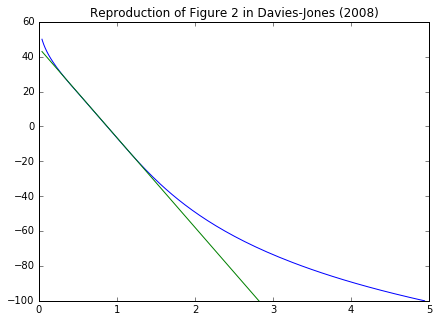

I know f() is working because:
Proving equation 3.1 works (the equivalent to thingy):
Theta_e at 273.15: 283.609914203
0.876630113672 == 0.876630113672
f= 0.876630113672
fprime calculated via Jacobian: -0.0192056049327
fprime calculated via analytical: -0.0192056050354
This number is close to the recorded 52.091 value in the paper: -52.0681331392
So is this number:  45.6444934725
Which makes sense given this equation: 45.674 - 51.091*np.power(C/theta_e, lambda_factor))


In [122]:
def f(tau, p):
    # Equation 2.3 from RDJ 2008
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    es = e_s(ktoc(tau))
    rs = r_s(tau, p)
    G = eqG(tau, rs)
    f_tau_pi = np.power(C / tau, lambda_factor) * \
               np.power(1 - (es / (p_0 * np.power(nondim_pres, lambda_factor))), lambda_factor * nu) * \
               np.power(nondim_pres, -lambda_factor * k_3 * rs) * \
               np.exp(-lambda_factor * G)
    return f_tau_pi

def dlnfdt(tau,p):
    # Solves equation A.1 from RDJ 2008
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    es = e_s(ktoc(tau))
    r_s = e2r(es, p) # convert to unitless
    des_dt = es * ((a * b)/np.power(tau - C + b,2))
    drs_dt = ((epsilon * p)/np.power(p - es,2)) * des_dt
    dG_dt = ((-k_0/np.power(tau,2)) * (r_s + k_2 * np.power(r_s,2))) + \
             (((k_0/tau) - k_1)*(1. + 2. * k_2 * r_s) * drs_dt)
    dlnf_dt = -lambda_factor * (((1./tau) + ((nu /(p - es)) * des_dt)) + \
                              (k_3 * k_d * np.log(p/p_0) * drs_dt) + dG_dt)
    
    return dlnf_dt, des_dt, drs_dt, dG_dt, es, r_s

def dlnf2dt2(tau, p, dlnf_dt, des_dt, drs_dt, dG_dt, f_tau_pi, es, rs):
    # tau - temp in C
    # p - pressure in p
    # dlnf_dt - dlnf_dt (eq. A.2)
    # des_dt - eq A.5
    # drs_dt - eq A.4
    # dG_dt - eq A.3
    # f_tau_pi = f[tau, pi]
    # es = saturation vapor pressure (mb)
    # rs = saturation mixing ratio (g/g)
    
    # Returns df2_dt2 or f''[tau,pi] (solves equation A.6 from RDJ 2008)
    des2_dt2 = ((a*b)/np.power(tau-C+b,2)) * (des_dt - ((2*es)/(tau-C+b)))
    drs2_dt2 = ((epsilon * p)/np.power(p-es,2)) * \
               (des2_dt2 - ((2/(p-es)) * np.power(des_dt,2)))
    dG2_dt2 = ((2 * k_0)/np.power(tau,3)) * (rs + k_2 * np.power(rs,2)) -\
              ((2 * k_0)/np.power(tau,2)) * (1 + 2 * k_2 * rs) * drs_dt +\
              ((k_0/tau) - k_1) * 2 * k_2 * np.power(drs_dt,2) + \
              ((k_0/tau) - k_1) * (1 + 2 * k_2 * rs * drs2_dt2)
    dlnf2_dt2 = lambda_factor * \
                ((1./np.power(tau,2)) - ((nu/np.power(p-es,2)) * np.power(des_dt,2)) -\
                ((nu/(p-es)) * des2_dt2) - \
                k_3 * k_d * np.log(p/p_0) * drs2_dt2 - dG2_dt2)
    return df_dt * dlnfdt(tau, p)[0] + f_tau_pi * dlnf2_dt2

tau_n = 273.15
theta_e = thetae(1000, 0, 0)
f_tau_pi = f(tau_n,1000.)
dlnf_dt, des_dt, drs_dt, dG_dt, es, rs = dlnfdt(tau,1000.)
df_dt = fprime = (f_tau_pi) * (dlnf_dtau)
df2_dt2 = dlnf2dt2(tau, 1000., dlnf_dt, des_dt, drs_dt, dG_dt, f_tau_pi, es, rs)
print f_tau_pi, df_dt, df2_dt2, theta_e, tau_n

# Plot RDJ 2007 Figure 2 for validation.
theta_w = np.arange(-100,51,1)
theta_e = thetae(np.ones(len(theta_w)) * 1000, theta_w, theta_w)
figure(figsize=(7,5))
title("Reproduction of Figure 2 in Davies-Jones (2008)")
plot(np.power(C/theta_e, lambda_factor), theta_w)
plot(np.power(C/theta_e, lambda_factor), 45.114 - 51.489*np.power(C/theta_e, lambda_factor))
ylim(-100,60)
show()

# Here I was concerned that my analytical function for df_dt was incorrect and needed to do some testing.
# I validated that the calculations made sense given some of the results in Section 3 of RDJ 2008.
tau_n = 273.15
deriv = (f(tau_n, 1000.) - f(tau_n+perturb, 1000.))/(tau_n - (tau_n + perturb))

print "I know f() is working because:"
print "Proving equation 3.1 works (the equivalent to thingy):"
print "Theta_e at 273.15:", thetae(1000, 0, 0)
print f(tau_n,1000.), '==', np.power(273.15/thetae(1000, 0, 0), lambda_factor)
print "f=",f(tau_n,1000.)
print "fprime calculated via Jacobian:", deriv
print "fprime calculated via analytical:", fprime
print "This number is close to the recorded 52.091 value in the paper:", 1./fprime
print "So is this number: ", -f(tau_n, 1000.)/fprime
print "Which makes sense given this equation: 45.674 - 51.091*np.power(C/theta_e, lambda_factor))"

RDJ 2007 Method Time: 0:00:01.241082
Wobus Method Time: 0:00:00.141837


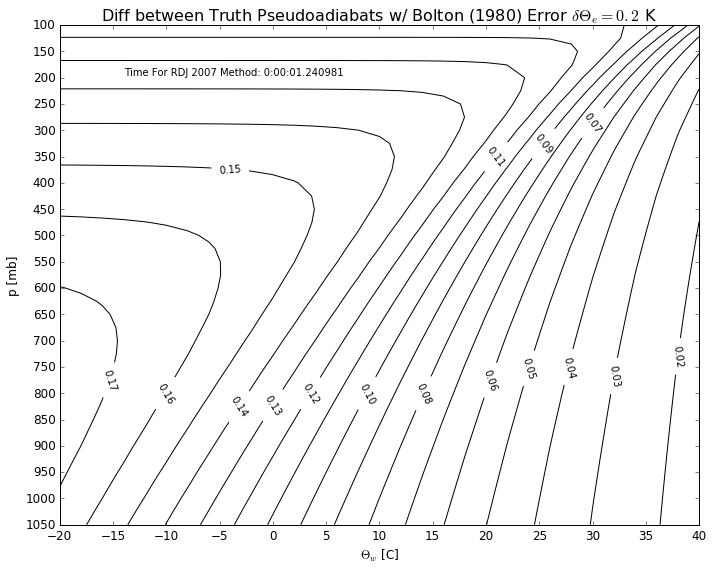

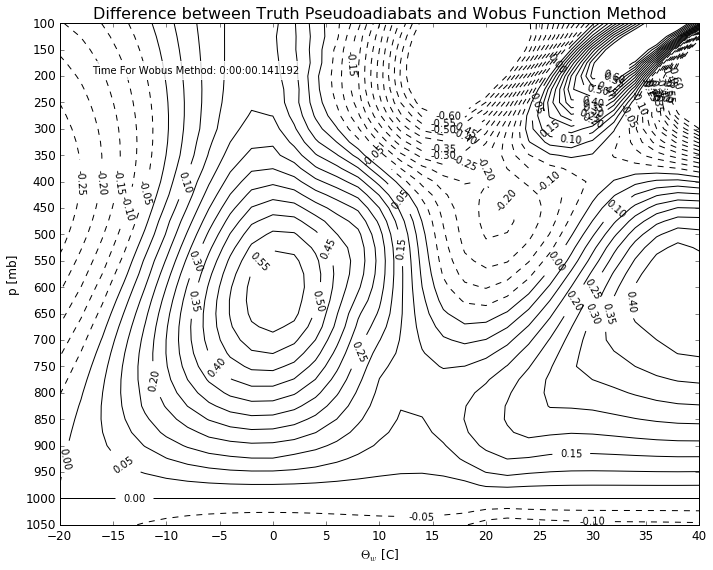

In [119]:
# Set up the testing grid.
pres_arr = np.arange(1050,75,-25)
theta_w = np.arange(-20,42,2)

def ps(pres_arr, theta_w, theta_e_err=0):
    # This function performs the non-accelerated version of the RDJ 2008 method.
    # in order to determine the "truth" pseudoadiabat values.
    thae = thetae(np.ones(len(theta_w)) * 1000, theta_w, theta_w) + theta_e_err
    lines = []
    for t,w in zip(thae,theta_w+273.15):
        #print t
        pseudoadiabat = []
        for p in pres_arr:
            #print p
            t_e = equivalent_temperature(t, p)
            nondim_pres = np.power(p / p_0, 1./lambda_factor)
            tau_n = np.min([t_e, w - (150.*(1-nondim_pres))]) # First guess tau_0
            baseterm = np.power(C/t_e,lambda_factor)
            for i in range(10):
                f_tau_pi = f(tau_n,p)
                dlnf_dtau = dlnfdt(tau_n,p)[0]
                df_dt = (f_tau_pi) * (dlnf_dtau)
                tau_n2 = tau_n - ((f_tau_pi - baseterm)/df_dt)
                error = tau_n2 - tau_n
                tau_n = tau_n2
            pseudoadiabat.append(tau_n)
        lines.append(pseudoadiabat)
    return np.asarray(lines)

def ps_wobus(pres_arr, theta_w, theta_e_err=0):
    # This function performs the Wobus function method (from SHARPpy) to calculate
    # the pseudoadiabat values.  It's used for comparison to the RDJ 2008 method results.
    lines = []
    for t in theta_w:
        pseudoadiabat = []
        for p in pres_arr:
            pseudoadiabat.append(wetlift(1000,t,p, conv=0.1))
        lines.append(pseudoadiabat)
    return np.asarray(lines)

dt = datetime.now()
truth = ps(pres_arr, theta_w)
rdj_time = datetime.now() - dt
print "RDJ 2007 Method Time:", datetime.now() - dt

error = ps(pres_arr, theta_w, theta_e_err=0.2)
dt = datetime.now()
wobus = ps_wobus(pres_arr, theta_w)
wobus_time = datetime.now() - dt
print "Wobus Method Time:", datetime.now() - dt

#Reproduce Figure 8 in RDJ 2008
figure(figsize=(10,8))
title("Diff between Truth Pseudoadiabats w/ Bolton (1980) Error $\delta\Theta_e=0.2$ K", fontsize=16)
c = contour(theta_w, pres_arr, (error-truth).T, np.arange(0,0.21, 0.01),colors='k')
#colorbar()
t = text(.1,.9, "Time For RDJ 2007 Method: " + str(rdj_time), transform=gca().transAxes)
t.set_bbox(dict(color='white', alpha=0.8, edgecolor='red'))
yticks(np.arange(1050,50,-50))
xticks(np.arange(-20,45,5))
clabel(c, fmt='%1.2f')
gca().invert_yaxis()
xlabel("$\Theta_{w}$ [C]", fontsize=12)
ylabel("p [mb]", fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
tight_layout()
savefig('truth_w_boltonerror.png', bbox_inches='tight')
show()

# Reproduce Figure 13 in RDJ 2008.
figure(figsize=(10,8))
title("Difference between Truth Pseudoadiabats and Wobus Function Method", fontsize=16)
c = contour(theta_w, pres_arr, (truth-wobus-273.15).T,np.arange(-.6,.65,0.05),colors='k')
#colorbar()
t = text(.05,.9, "Time For Wobus Method: " + str(wobus_time), transform=gca().transAxes)
t.set_bbox(dict(color='white', alpha=0.8, edgecolor='red'))
yticks(np.arange(1050,50,-50))
xticks(np.arange(-20,45,5))
clabel(c, fmt='%1.2f')
gca().invert_yaxis()
xticks(fontsize=12)
yticks(fontsize=12)
xlabel("$\Theta_{w}$ [C]", fontsize=12)
ylabel("p [mb]", fontsize=12)
tight_layout()
savefig('wobus_truth_diff.png', bbox_inches='tight')
show()

In [9]:
def dlnf2dt2(tau, p, dlnf_dt, des_dt, drs_dt, dG_dt, f_tau_pi, es, rs):
    # tau - temp in C
    # p - pressure in p
    # dlnf_dt - dlnf_dt (eq. A.2)
    # des_dt - eq A.5
    # drs_dt - eq A.4
    # dG_dt - eq A.3
    # f_tau_pi = f[tau, pi]
    # es = saturation vapor pressure
    # rs = saturation mixing ratio
    # Returns df2_dt2 or f''[tau,pi] (eq. A.6)
    des2_dt2 = ((a*b)/np.power(tau-C+b,2)) * (des_dt - ((2*es)/(tau-C+b)))
    drs2_dt2 = ((epsilon * p)/np.power(p-es,2)) * \
               (des2_dt2 - ((2/(p-es)) * np.power(des_dt,2)))
    dG2_dt2 = (((2 * k_0)/np.power(tau,3)) * (rs + (k_2 * np.power(rs,2)))) -\
              (((2 * k_0)/np.power(tau,2)) * (1 + (2 * k_2 * rs)) * drs_dt) +\
              (((k_0/tau) - k_1) * 2 * k_2 * np.power(drs_dt,2)) + \
              ((((k_0/tau) - k_1) * (1 + (2 * k_2 * rs))) * drs2_dt2) 
    dlnf2_dt2 = lambda_factor * \
                ((1./np.power(tau,2)) - ((nu/np.power(p-es,2)) * np.power(des_dt,2)) -\
                ((nu/(p-es)) * des2_dt2) - \
                k_3 * k_d * np.log(p/p_0) * drs2_dt2 - dG2_dt2)

    return dlnf2_dt2

# Setting up validation grid
pres_arr = np.arange(1050,75,-25)
theta_w = np.arange(-20,42,2)

In [10]:
# Needed to do some tests to see if the analytical calculations of the derivatives
# were matching up with the calculations from finite differencing.
tau = 273.15
p = 1000.
perturb = 0.000001

rs = r_s(tau, p)
es = e_s(tau - C)
print rs, es

print "Analytic des2_dt2:"
des_dta = e_s(tau-C) * ((a * b)/np.power(tau - C + b,2))
des2_dt2a = ((a*b)/np.power(tau - C + b,2)) * (des_dta - ((2*es)/(tau - C + b)))
print des2_dt2a
print "Jacobian des2_dt2:"
des2_dt2j = (e_s(tau-C+perturb) - 2*e_s(tau-C) + e_s(tau-C-perturb))/np.power(perturb,2)
print des2_dt2j

print 

print "Analytic drs_dt:"
drs_dta = ((epsilon * p)/np.power(p - e_s(tau-C),2)) * des_dta
print drs_dta
print "Analytic drs2_dt2:"
drs_dta = ((epsilon * p)/np.power(p - e_s(tau-C),2)) * des_dta
drs2_dt2a = ((epsilon * p)/np.power(p - es,2)) * \
             (des2_dt2a - ((2./(p-es)) * np.power(des_dta,2)))
print drs2_dt2a

print "Jacobian drs_dt:"
drs_dtj = (r_s(tau+perturb, p) - r_s(tau, p))/perturb
print drs_dtj
print "Jacobian drs2_dt2:"
drs2_dt2j = (r_s(tau+perturb, p) - 2*r_s(tau, p) + r_s(tau-perturb, p))/np.power(perturb,2)
print drs2_dt2j

print

print "Analytic dG_dt:"
dG_dta = ((-k_0/np.power(tau,2)) * (r_s(tau,p) + k_2 * np.power(r_s(tau,p),2))) + \
         (((k_0/tau) - k_1)*(1. + 2. * k_2 * r_s(tau,p)) * drs_dta)
print dG_dta
print "Analytic dG2_dt2:"
dG_dta = ((-k_0/np.power(tau,2)) * (r_s(tau,p) + k_2 * np.power(r_s(tau,p),2))) + \
         (((k_0/tau) - k_1)*(1. + 2. * k_2 * r_s(tau,p)) * drs_dta)
dG2_dt2a = (((2 * k_0)/np.power(tau,3)) * (rs + (k_2 * np.power(rs,2)))) -\
          (((2 * k_0)/np.power(tau,2)) * (1 + (2 * k_2 * rs)) * drs_dta) +\
          (((k_0/tau) - k_1) * 2 * k_2 * np.power(drs_dta,2)) + \
          ((((k_0/tau) - k_1) * (1 + (2 * k_2 * rs))) * drs2_dt2a)    
print dG2_dt2a

print "Jacobian dG_dt:"
dG_dtj = (eqG(tau+perturb, r_s(tau+perturb,p)) - eqG(tau, r_s(tau,p)))/perturb
print dG_dtj  
print "Jacobian dG2_dt2:"
dG2_dt2j = (eqG(tau+perturb, r_s(tau+perturb,p)) - 2 * eqG(tau, r_s(tau,p)) + eqG(tau-perturb, r_s(tau-perturb,p)))/np.power(perturb,2)
print dG2_dt2j  

print
print "Analytic df2_dt2:"
f_tau_pi = f(tau_n, p)
dlnf_dtau = dlnfdt(tau_n,p)[0]
dlnf2_dt2 = lambda_factor * \
            ((1./np.power(tau,2)) - ((nu/np.power(p-es,2)) * np.power(des_dta,2)) -\
            ((nu/(p-es)) * des2_dt2a) - \
            (k_3 * k_d * np.log(p/p_0) * drs2_dt2a) - dG2_dt2a)
#print f_tau_pi, dlnf_dtau, dlnf2_dt2
print df_dt * dlnf_dtau + f_tau_pi * dlnf2_dt2
print "Jacobian df2_dt2:"
df2_dt2j = (f(tau+perturb,p) - 2 * f(tau, p) + f(tau-perturb, p))/np.power(perturb,2)
print df2_dt2j

0.00383133946018 6.122
Analytic des2_dt2:
0.0285891300431
Jacobian des2_dt2:
0.0293098878501

Analytic drs_dt:
0.000279740366256
Analytic drs2_dt2:
1.77521006059e-05
Jacobian drs_dt:
0.000279740374528
Jacobian drs2_dt2:
1.82145964978e-05

Analytic dG_dt:
0.00246410790379
Analytic dG2_dt2:
0.00014523463262
Jacobian dG_dt:
0.00246410797322
Jacobian dG2_dt2:
0.000152655665886

Analytic df2_dt2:


NameError: name 'df_dt' is not defined

RDJ08 Method Time: 0:00:00.019425
Wobus Method Time: 0:00:00.137655
<built-in method total_seconds of datetime.timedelta object at 0x1129d7c60>



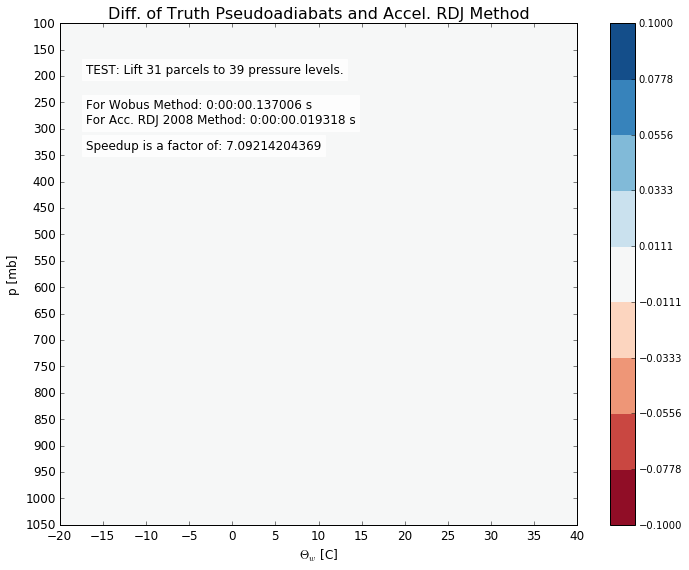

In [114]:
def guess_wetbulb(thetae, p):
    # Provides the first guess for the pseudoadiabat wetbulb temperture given a unique pseudoadiabat
    # that is determined by Theta_e and pressure.  Currently this only supports when you input these
    # to variables as arrays.
    t_e = equivalent_temperature(thetae, p) # returns in Kelvin
    nondim_pres = np.power(p / p_0, 1./lambda_factor)
    normalized_t_e = np.power(C / t_e, lambda_factor) # Unitless
    D = np.power(0.1859 * (p/1000.) + 0.6512, -1)
    r_s = e2r(e_s(ktoc(t_e)), p)# * (1./1000.)
    deriv = ((a * b)/np.power(ktoc(t_e) + b,2))

    t_w = np.empty(len(t_e))
    k1_pi = -38.5*np.power(nondim_pres, 2) + 137.81*nondim_pres - 53.737 # RDJ 2007 Eq 4.3
    k2_pi = -4.392*np.power(nondim_pres, 2) + 56.831*nondim_pres - 0.384 # RDJ 2007 Eq 4.4

    # Criteria 1 (RDJ 2007 Eq 4.8)
    idx = np.where(normalized_t_e > D)#[0]
    t_w[idx] = ktoc(t_e[idx]) - ((A * r_s[idx]) / (1 + A*r_s[idx]*deriv[idx]))
    # Criteria 2 (RDJ 2007 Eq 4.9)
    idx = np.where((1 <= normalized_t_e) & (normalized_t_e <= D))#[0]
    t_w[idx] = k1_pi[idx] - k2_pi[idx] * normalized_t_e[idx]
    # Criteria 3 (RDJ 2007 Eq 4.10)
    idx = np.where((0.4 <= normalized_t_e) & (normalized_t_e < 1))#[0]
    t_w[idx] = (k1_pi[idx] - 1.21) - ((k2_pi[idx] - 1.21) * normalized_t_e[idx])
    # Criteria 4 (RDJ 2007 Eq 4.11)
    idx = np.where(normalized_t_e < 0.4)#[0]
    t_w[idx] = (k1_pi[idx] - 2.66) - ((k2_pi[idx] - 1.21) * normalized_t_e[idx]) + (0.58 * np.power(normalized_t_e[idx], -1))  
    
    return t_w, t_e, nondim_pres

def ps_accel(pres_arr, theta_w, theta_e_err=0):
    # Performs the accelerated RDJ 2008 method of calculating the pseudoadiabats 
    # Currently only performs these calculations on a grid and is tested for 1-D arrays.
    # of Theta_w and pres_arr
    thae = thetae(np.ones(len(theta_w)) * 1000, theta_w, theta_w) + theta_e_err
    lines = []
    for t,w in zip(thae,theta_w+273.15): 
        # Get the array of Theta-E values to define the pseudoadiabat
        theta_es = np.ones(len(pres_arr)) * t
        # Calculate the equivalent temperture for each pressure along the pseudoadiabat
        t_e = equivalent_temperature(theta_es, pres_arr)
        nondim_pres = np.power(pres_arr / p_0, 1./lambda_factor)
        # Get the improved first guess of T_w along the pseudoadiabat (Eq 4.8-4.11)
        tau_n, t_e, nondim_pres = guess_wetbulb(theta_es, pres_arr)
        tau_n = ctok(tau_n) # Convert the first guess to Celsius
        baseterm = np.power(C/t_e,lambda_factor)
        # Get the derivative terms to perform Newton's Method
        f_tau_pi = f(tau_n, pres_arr)
        dlnf_dt, des_dt, drs_dt, dG_dt, es, rs = dlnfdt(tau_n, pres_arr)
        df_dt = (f_tau_pi) * (dlnf_dt)
        dlnf2_dt2 = dlnf2dt2(tau_n, pres_arr, dlnf_dt, des_dt, drs_dt, dG_dt, f_tau_pi, es, rs)
        df2_dt2 = df_dt * dlnf_dt + f_tau_pi * dlnf2_dt2
        # Equation 2.8 in RDJ 2008 is flawed, but reference to Henrici 1964 is valid.
        # Using that equation instead.  See Eq 10-4 on pg 199 of Henrici:
        # https://ia800700.us.archive.org/23/items/ElementsOfNumericalAnalysis/Henrici-ElementsOfNumericalAnalysis.pdf
        c = f_tau_pi - baseterm
        b = df_dt
        a = df2_dt2/2.
        # Compute the roots for the accelerated method
        quad_tau_n1 = tau_n - ((2.*c)/(b + np.power(np.power(b,2) - 4.*a*c,0.5)))
        quad_tau_n2 = tau_n - ((2.*c)/(b - np.power(np.power(b,2) - 4.*a*c,0.5)))
        # Compute the increment for the non-accelerated method
        lin_tau_n2 = tau_n - (c/df_dt)
        # Pick the accelerated method root that is closest to the result from the non-accelerated method.
        idx = np.argmin(np.abs(np.asarray([quad_tau_n1, quad_tau_n2]) - lin_tau_n2), axis=0)
        pseudoadiabat = np.asarray([quad_tau_n1, quad_tau_n2])[idx[0],:]       
        lines.append(pseudoadiabat)
    return np.asarray(lines)

truth = ps(pres_arr, theta_w)
dt = datetime.now()
truth_acc = ps_accel(pres_arr, theta_w)
rdj_acc_time = datetime.now() - dt
print "RDJ08 Method Time:", datetime.now() - dt

dt = datetime.now()
wobus = ps_wobus(pres_arr, theta_w)
wobus_time = datetime.now() - dt
print "Wobus Method Time:", datetime.now() - dt

figure(figsize=(10,8))
title("Diff. of Truth Pseudoadiabats and Accel. RDJ Method", fontsize=16)
c = contourf(theta_w, pres_arr, (truth_acc-truth).T, np.linspace(-.1, 0.1,10), cmap='RdBu')#, colors='k')
#colorbar()
yticks(np.arange(1050,50,-50))
xticks(np.arange(-20,45,5))
#clabel(c, fmt='%1.2f')
colorbar(c)
gca().invert_yaxis()
t = text(.05,.9, "TEST: Lift " + str(len(theta_w)) + ' parcels to ' + str(len(pres_arr)) + ' pressure levels.', fontsize=12, transform=gca().transAxes)
t.set_bbox(dict(color='white', alpha=0.8, edgecolor='red'))
t = text(.05,.8, "For Wobus Method: " + str(wobus_time) + ' s\nFor Acc. RDJ 2008 Method: ' + str(rdj_acc_time) + ' s', fontsize=12, transform=gca().transAxes)
t.set_bbox(dict(color='white', alpha=0.8, edgecolor='red'))
t = text(.05,.75, "Speedup is a factor of: " + str(wobus_time.total_seconds()/rdj_acc_time.total_seconds()), fontsize=12, transform=gca().transAxes)
t.set_bbox(dict(color='white', alpha=0.8, edgecolor='red'))
xlabel("$\Theta_{w}$ [C]", fontsize=12)
ylabel("p [mb]", fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
print wobus_time.total_seconds
tight_layout()
print 
savefig('truth_minus_accel.png', bbox_inches='tight')
show()

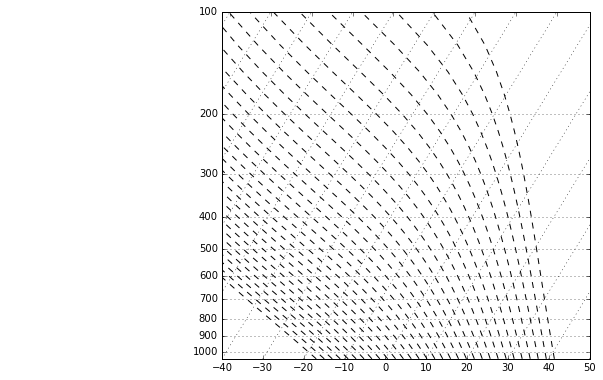

In [118]:
# This serves as an intensive exercise of matplotlib's transforms
# and custom projection API. This example produces a so-called
# SkewT-logP diagram, which is a common plot in meteorology for
# displaying vertical profiles of temperature. As far as matplotlib is
# concerned, the complexity comes from having X and Y axes that are
# not orthogonal. This is handled by including a skew component to the
# basic Axes transforms. Additional complexity comes in handling the
# fact that the upper and lower X-axes have different data ranges, which
# necessitates a bunch of custom classes for ticks,spines, and the axis
# to handle this.

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection

# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        if not self.get_visible(): return
        renderer.open_group(self.__name__)

        lower_interval = self.axes.xaxis.lower_interval
        upper_interval = self.axes.xaxis.upper_interval

        if self.gridOn and transforms.interval_contains(
                self.axes.xaxis.get_view_interval(), self.get_loc()):
            self.gridline.draw(renderer)

        if transforms.interval_contains(lower_interval, self.get_loc()):
            if self.tick1On:
                self.tick1line.draw(renderer)
            if self.label1On:
                self.label1.draw(renderer)

        if transforms.interval_contains(upper_interval, self.get_loc()):
            if self.tick2On:
                self.tick2line.draw(renderer)
            if self.label2On:
                self.label2.draw(renderer)

        renderer.close_group(self.__name__)


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def __init__(self, *args, **kwargs):
        maxis.XAxis.__init__(self, *args, **kwargs)
        self.upper_interval = 0.0, 1.0

    def _get_tick(self, major):
        return SkewXTick(self.axes, 0, '', major=major)

    @property
    def lower_interval(self):
        return self.axes.viewLim.intervalx

    def get_view_interval(self):
        return self.upper_interval[0], self.axes.viewLim.intervalx[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        trans = self.axes.transDataToAxes.inverted()
        if self.spine_type == 'top':
            yloc = 1.0
        else:
            yloc = 0.0
        left = trans.transform_point((0.0, yloc))[0]
        right = trans.transform_point((1.0, yloc))[0]

        pts  = self._path.vertices
        pts[0, 0] = left
        pts[1, 0] = right
        self.axis.upper_interval = (left, right)


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(111,
    # projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        #Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines['top'].register_axis(self.xaxis)
        self.spines['bottom'].register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines['left'].register_axis(self.yaxis)
        self.spines['right'].register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top':SkewSpine.linear_spine(self, 'top'),
                  'bottom':mspines.Spine.linear_spine(self, 'bottom'),
                  'left':mspines.Spine.linear_spine(self, 'left'),
                  'right':mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        #Get the standard transform setup from the Axes base class
        Axes._set_lim_and_transforms(self)

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = self.transScale + (self.transLimits +
                transforms.Affine2D().skew_deg(rot, 0))

        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (transforms.blended_transform_factory(
                    self.transScale + self.transLimits,
                    transforms.IdentityTransform()) +
                transforms.Affine2D().skew_deg(rot, 0)) + self.transAxes

# Now register the projection with matplotlib so the user can select
# it.
register_projection(SkewXAxes)

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)
ax.semilogy(truth.T-273.15, pres_arr, 'k--')
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,50)
show()